In [1]:
#@title import
import collections
import functools
import numpy as np
from typing import List, Iterable, Any, Union, Optional, overload
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from scipy.linalg import dft
from tqdm import notebook
import string
from google.colab import files

In [2]:
#@title Topology Functions
def dynamic_exp2(iter, size=8):
  tau = np.ceil(np.log2(size))
  _iter = iter % tau
  return _dynamic_exp2(_iter, size)

@functools.cache
def _dynamic_exp2(iter, size):
  W = np.zeros([size, size])
  for i in range(size):
    for j in range(size):
      if (j == i) or (np.log2((j-i) % size) == iter):
        W[i,j] = 1/2
  return W

def static_exp2(iter, size):
  del iter
  return _static_exp2(size)

@functools.cache
def _static_exp2(size):
  # assert size & (size-1) == 0
  x = np.array([1.0 if i & (i - 1) == 0 else 0 for i in range(size)])
  x /= x.sum()
  topo = np.empty((size, size))
  for i in range(size):
      topo[i] = np.roll(x, i)
  return topo

def decompose(n, factors):
  result = []
  residue = n
  for k in range(1, len(factors)):
    base = np.prod(factors[k:])
    quotient, residue = divmod(residue, base)
    result.append(quotient)
  result.append(residue)
  return result

def diff_by_one(list1: list[int], list2: list[int]) -> bool:
  if len(list1) != len(list2):
    raise ValueError
  diff = 0
  for i, j in zip(list1, list2):
    diff += 0 if i == j else 1
  return diff == 1

def diff_by_shift_one(list1: list[int], list2: list[int]) -> bool:
  if len(list1) != len(list2):
    raise ValueError
  diff = 0
  for i, j in zip(list1[1:], list2[:-1]):
    diff += 0 if i == j else 1
  return diff == 0

def static_hypercuboid(iter, factors):
  del iter
  return _static_hypercuboid(tuple(factors))

@functools.cache
def _static_hypercuboid(factors):
  size = int(np.prod(factors))
  W = np.zeros((size, size))
  for i in range(size):
    i_decomposed = decompose(i, factors)
    for j in range(size):
      if i == j:
        W[i, j] = 1
        continue
      j_decomposed = decompose(j, factors)
      if diff_by_one(i_decomposed, j_decomposed):
        W[i, j] = 1
  return W / W.sum(axis=1)

def static_de_bruijn(iter, factors):
  del iter
  return _static_static_de_bruijn(tuple(factors))

@functools.cache
def _static_static_de_bruijn(factors):
  size = int(np.prod(factors))
  W = np.zeros((size, size))
  for i in range(size):
    i_decomposed = decompose(i, factors)
    for j in range(size):
      j_decomposed = decompose(j, factors)
      if diff_by_shift_one(i_decomposed, j_decomposed):
        W[i, j] = 1
  return W / W.sum(axis=1)

def dynamic_hypercuboid(iter, factors):
  _iter = iter % len(factors)
  return _dynamic_hypercuboid(_iter, tuple(factors))

@functools.cache
def _dynamic_hypercuboid(iter, factors):
  W = 1
  for i, f in enumerate(factors):
    W_i = np.ones([f, f]) / f if i == iter else np.eye(f)
    W = np.kron(W_i, W)
  return W



def ring(size):
  x = np.array([1.0 if i in (0, 1, size-1) else 0 for i in range(size)])
  x /= x.sum()
  topo = np.empty((size, size))
  for i in range(size):
      topo[i] = np.roll(x, i)
  return topo


def _2D_MeshGrid(size):
  n = int(np.sqrt(size))
  topo = np.zeros((size, size))
  # Define the connections
  for i in range(n):
      for j in range(n):
          index = i * n + j
          topo[index, index]=1.0
          if i > 0:  # Connect to the node above
              topo[index, index - n] = 1.0
          if i < n - 1:  # Connect to the node below
              topo[index, index + n] = 1.0
          if j > 0:  # Connect to the node on the left
              topo[index, index - 1] = 1.0
          if j < n - 1:  # Connect to the node on the right
              topo[index, index + 1] = 1.0

  row_sums = topo.sum(axis=1).reshape(-1, 1)
  topo_normalized = topo / row_sums
  # print(size)
  # print(topo_normalized)
  return topo_normalized
# def _2D_MeshGrid(size):
#     n = int(np.sqrt(size))
#     topo = np.zeros((size, size))

#     for row in range(n):
#         for col in range(n):
#             index = row * n + col
#             connections = []
#             # 上
#             if row > 0:
#                 connections.append((row - 1) * n + col)
#             # 下
#             if row < n - 1:
#                 connections.append((row + 1) * n + col)
#             # 左
#             if col > 0:
#                 connections.append(row * n + (col - 1))
#             # 右
#             if col < n - 1:
#                 connections.append(row * n + (col + 1))
#             for c in connections:
#                 topo[index, c] = 1
#             topo[index, index] = 1
#     for i in range(size):
#         topo[i, :] /= topo[i, :].sum()
#     print(topo)
#     return topo
def StarGraph(size):
  n = int(np.sqrt(size))
  topo = np.zeros((size, size))
  topo[0, :] = 1
  topo[:, 0] = 1
  topo[0, 0] = 1
  for i in range(n):
    for j in range(n):
        index = i * n + j
        topo[index, index]=1.0
  row_sums = topo.sum(axis=1).reshape(-1, 1)
  topo_normalized = topo / row_sums

  return topo_normalized

In [3]:
# @title Helper Functions for Linear Regression

def generate_linear(num_data, dimension, num_workers, noise_level):
  """ Generates N data pairs (A_i, b_i) of dimension d that follow a linear
  regression model.
  """
  A = np.random.randn(num_data, dimension)
  x_o = np.random.randn(dimension, 1)
  ns = noise_level * np.random.randn(num_data, 1)
  b = A.dot(x_o) + ns

  x_opt = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

  As = []
  bs = []
  for i in range(num_workers):
      As.append(A[i::num_workers])
      bs.append(b[i::num_workers])
  return As, bs, x_opt

def grad_fn_agent(x, Aarr, barr, worker_index, reg, noise = False):
  """ Returns the gradient of the least squares problem with non-convex
  regularizer.
  """
  A = Aarr[worker_index]
  b = barr[worker_index]
  if noise:
    mu, sigma = 0, 0.0001 # mean and standard deviation
    s = np.random.normal(mu, sigma, x.shape)
    return A.T.dot(A.dot(x) - b) + reg*1/((x+1)**2+1e-8) + s
  return A.T.dot(A.dot(x) - b) + reg*1/((x+1)**2+1e-8)


def grad_fn_global(xfull, Aarr, barr, reg):

  x_avg = np.average(xfull, axis=1)[:, np.newaxis]
  grad_global = np.zeros_like(x_avg)
  for a in range(len(Aarr)):
    grad_global += grad_fn_agent(x_avg, Aarr, barr, a, reg)
  grad_global /= len(Aarr)
  return grad_global

def grad_avg(xfull, Aarr, barr, reg):

  x_avg = np.average(xfull, axis=1)[:, np.newaxis]
  grad_avg = np.zeros_like(x_avg)
  for a in range(len(Aarr)):
    grad_avg += grad_fn_agent(xfull[:, [a]], Aarr, barr, a, reg)
  grad_avg /= len(Aarr)
  return grad_avg

In [4]:
#@title Generate Data
num_data = 500 #@param
dimension = 20 #@param
num_workers = 64 #@param
noise_level = 0.01  #@param

As, bs, x_opt = generate_linear(num_data*num_workers, dimension, num_workers, noise_level)

In [5]:
def run_alg_gradient_tracking(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, reg=0.01, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator

    for ite in notebook.tqdm(range(max_iters)):

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)
      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        # x_curr[:, [a]] /= np.sum(x_curr)
      x_curr = x_curr @ W.T
      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()


    return sum_exponential


In [13]:
def run_alg_local_updates(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, nc = 5, reg=0.01, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator

    for ite in notebook.tqdm(range(max_iters)):

      for n in range(nc):
        grad_global = grad_fn_global(x_curr, As, bs, reg)
        grad_square_global = np.linalg.norm(grad_global)**2

        grad_average = grad_avg(x_curr, As, bs, reg)
        grad_square_avg = np.linalg.norm(grad_average)**2

        sum_exponential.append(grad_square_global+grad_square_avg)
        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)
        x_prev = x_curr.copy()

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)
      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        # x_curr[:, [a]] /= np.sum(x_curr)
      x_curr = x_curr @ W.T
      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()


    return sum_exponential


In [14]:
def run_alg_global_averaging(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, reg=0.01, noise=False):
    sum_exponential = []
    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator

    for ite in notebook.tqdm(range(max_iters)):

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)

      if (ite + 1) % T == 0:

        sum_of_neighbors = np.sum(x_curr - eta * g_curr, axis=1)
        x_curr = np.tile(sum_of_neighbors / num_workers, (num_workers, 1)).T

        sum_of_gradients = np.sum(g_curr, axis=1)
        g_avg = np.tile(sum_of_gradients / num_workers, (num_workers, 1)).T

        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_avg[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()
      else:
        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
          # x_curr[:, [a]] /= np.sum(x_curr)
        x_curr = x_curr @ W.T
        g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()


    return sum_exponential


In [15]:
0.*-+
interval = 50
# max_iters=1000
ret_StarGraph_GT = run_alg_gradient_tracking(
    graph_generator=StarGraph(size=num_workers), eta=0.0001, alpha=1, max_iters=1000, reg=0.001, noise=True
)

# ret_StarGraph_GT_Local_update_5 = run_alg_local_updates(
#     graph_generator=StarGraph(size=num_workers),
#     eta=0.0005, alpha=1, T=200, max_iters=200, nc = 5, reg=0.001, noise=True
# )

ret_StarGraph_GT_Local_update_20 = run_alg_local_updates(
    graph_generator=StarGraph(size=num_workers),
    eta=0.0001, alpha=1, T=200, max_iters=50, nc = 20, reg=0.00001, noise=True
)

ret_StarGraph_GT_Local_update_50 = run_alg_local_updates(
    graph_generator=StarGraph(size=num_workers),
    eta=0.0001, alpha=1, T=200, max_iters=20, nc = 50, reg=0.000001, noise=True
)
ret_StarGraph_GT_Local_update_100 = run_alg_local_updates(
    graph_generator=StarGraph(size=num_workers),
    eta=0.00005, alpha=1, T=200, max_iters=10, nc = 100, reg=0, noise=True
)
ret_StarGraph_GT_with_global_averaging_T100 = run_alg_global_averaging(
    graph_generator=StarGraph(size=num_workers),
    eta=0.0002, alpha=1, T=100, max_iters=1000, reg=0.001, noise=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

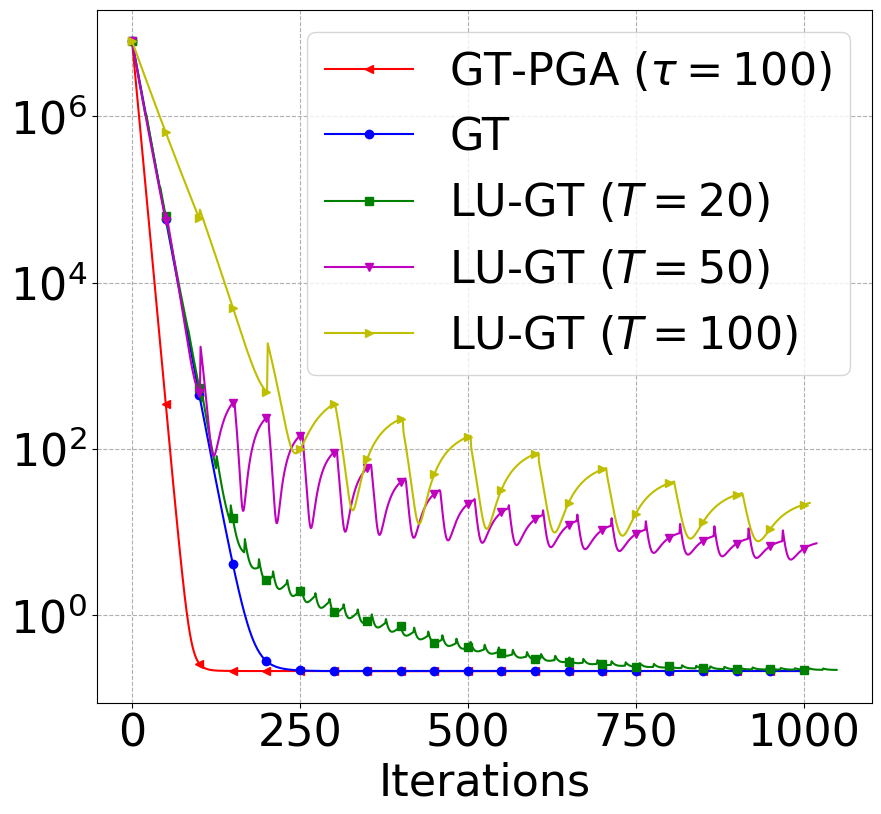

In [16]:
plt_StarGraph = plt.figure(figsize=(10, 9))

plt.plot(ret_StarGraph_GT_with_global_averaging_T100, '-<', label=r'GT-PGA ($\tau=100$)', markevery=interval, color='r')
plt.plot(ret_StarGraph_GT, '-o', label='GT', markevery=interval, color='b')
# plt.plot(ret_StarGraph_GT_Local_update_5, '-^', label=r'GT-LocalUpdates ($ng=5$)', markevery=interval)
plt.plot(ret_StarGraph_GT_Local_update_20, '-s', label=r'LU-GT ($T=20$)', markevery=interval, color='g')
plt.plot(ret_StarGraph_GT_Local_update_50, '-v', label=r'LU-GT ($T=50$)', markevery=interval, color='m')
plt.plot(ret_StarGraph_GT_Local_update_100, '->', label=r'LU-GT ($T=100$)', markevery=interval, color='y')

plt.yscale('log')

plt.legend()

# plt.title('Star', fontsize=32)
plt.xlabel('Iterations', fontsize=32)
# plt.ylabel(r'$\|\overline{\nabla f} (x^{(k)})\|^2 + \|\nabla f(\bar x^{(k)})\|^2$')
mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rc('legend', fontsize=32)

plt.grid(True, which="both", ls="--")
plt_StarGraph.savefig("star.pdf", format='pdf')
files.download("star.pdf")
plt.show()

In [17]:
interval = 50
# max_iters=1000
ret_2D_MeshGrid_GT = run_alg_gradient_tracking(
    graph_generator=_2D_MeshGrid(size=num_workers), eta=0.00005, alpha=1, max_iters=1000, reg=0.0001, noise=True
)

# ret_2D_MeshGrid_GT_Local_update_5 = run_alg_local_updates(
#     graph_generator=_2D_MeshGrid(size=num_workers),
#     eta=0.00007, alpha=1, T=200, max_iters=200, nc = 5, reg=0.0001, noise=True
# )

ret_2D_MeshGrid_GT_Local_update_20 = run_alg_local_updates(
    graph_generator=_2D_MeshGrid(size=num_workers),
    eta=0.00007, alpha=1, T=200, max_iters=50, nc = 20, reg=0.00001, noise=True
)

ret_2D_MeshGrid_GT_Local_update_50 = run_alg_local_updates(
    graph_generator=_2D_MeshGrid(size=num_workers),
    eta=0.00007, alpha=1, T=200, max_iters=20, nc = 50, reg=0.00001, noise=True
)
ret_2D_MeshGrid_GT_Local_update_100 = run_alg_local_updates(
    graph_generator=_2D_MeshGrid(size=num_workers),
    eta=0.00007, alpha=1, T=200, max_iters=10, nc = 100, reg=0.00001, noise=True
)
ret_2D_MeshGrid_GT_with_global_averaging_T200 = run_alg_global_averaging(
    graph_generator=_2D_MeshGrid(size=num_workers),
    eta=0.00007, alpha=1, T=200, max_iters=1000, reg=0.0001, noise=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

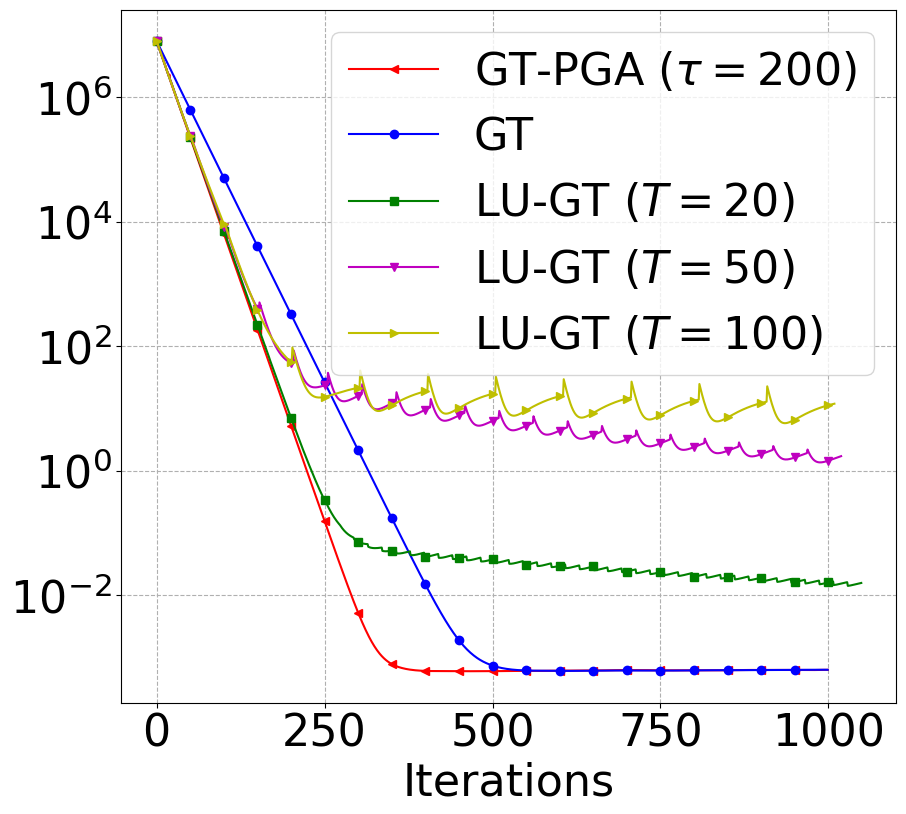

In [19]:
plt_2D_MeshGrid = plt.figure(figsize=(10, 9))

plt.plot(ret_2D_MeshGrid_GT_with_global_averaging_T200, '-<', label=r'GT-PGA ($\tau=200$)', markevery=interval, color='r')
plt.plot(ret_2D_MeshGrid_GT, '-o', label='GT', markevery=interval, color='b')
# plt.plot(ret_2D_MeshGrid_GT_Local_update_5, '-^', label=r'GT-LocalUpdates ($ng=5$)', markevery=interval)
plt.plot(ret_2D_MeshGrid_GT_Local_update_20, '-s', label=r'LU-GT ($T=20$)', markevery=interval, color='g')
plt.plot(ret_2D_MeshGrid_GT_Local_update_50, '-v', label=r'LU-GT ($T=50$)', markevery=interval, color='m')
plt.plot(ret_2D_MeshGrid_GT_Local_update_100, '->', label=r'LU-GT ($T=100$)', markevery=interval, color='y')

plt.yscale('log')


plt.legend()

# plt.title('2D MeshGrid', fontsize=32)
plt.xlabel('Iterations', fontsize=32)
# plt.ylabel('')
mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rc('legend', fontsize=32)

plt.grid(True, which="both", ls="--")
plt_2D_MeshGrid.savefig("mesh.pdf", format='pdf')
files.download("mesh.pdf")
plt.show()

In [6]:
def run_alg_ring_noAveraging(graph_generator, eta=0.0002, alpha=1, T=200, max_iters=10000, reg=10, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    # 获取W矩阵，因为在新算法中W是固定的
    W = graph_generator

    for ite in notebook.tqdm(range(max_iters)):
      # 计算相对误差并存储
      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
      x_curr = x_curr @ W.T

      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()
      # if ite % 200 == 0:
      sum_exponential.append(grad_square_global+grad_square_avg)

    return sum_exponential


In [7]:
def run_alg_ring_Local_updates(graph_generator, eta=0.0002, alpha=1, T=200, max_iters=10000, ng = 5, reg=10, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    # 获取W矩阵，因为在新算法中W是固定的
    W = graph_generator

    for ite in notebook.tqdm(range(max_iters)):
      for n in range(ng):

        grad_global = grad_fn_global(x_curr, As, bs, reg)
        grad_square_global = np.linalg.norm(grad_global)**2
        grad_average = grad_avg(x_curr, As, bs, reg)
        grad_square_avg = np.linalg.norm(grad_average)**2
        sum_exponential.append(grad_square_global+grad_square_avg)

        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()

      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
      x_curr = x_curr @ W.T

      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()
      # if ite % 200 == 0:
      sum_exponential.append(grad_square_global+grad_square_avg)

    return sum_exponential


In [8]:
def run_alg_ring_Averaging(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, reg=0.001, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    # 获取W矩阵，因为在新算法中W是固定的
    W = graph_generator
    W_full = np.ones((num_workers, num_workers)) / num_workers
    for ite in notebook.tqdm(range(max_iters)):
      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2
      sum_exponential.append(grad_square_global+grad_square_avg)
      if (ite + 1) % T == 0:

        sum_of_neighbors = np.sum(x_curr - eta * g_curr, axis=1)
        x_curr = np.tile(sum_of_neighbors / num_workers, (num_workers, 1)).T

        sum_of_gradients = np.sum(g_curr, axis=1)
        g_avg = np.tile(sum_of_gradients / num_workers, (num_workers, 1)).T

        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_avg[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()
      else:
        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        x_curr = x_curr @ W.T

        g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()
      # if ite % 200 == 0:


    return sum_exponential


In [9]:
ret_ring_GT_without_global_averaging = run_alg_ring_noAveraging(graph_generator=ring(size=num_workers), eta=0.00005, alpha = 1,T=200, max_iters = 5000, reg=0.001)

ret_ring_GT_Local_Update_20 = run_alg_ring_Local_updates(graph_generator=ring(size=num_workers), eta=0.0001, alpha = 1,T=200, max_iters = 250, ng=20, reg=0.00001)

ret_ring_GT_Local_Update_50 = run_alg_ring_Local_updates(graph_generator=ring(size=num_workers), eta=0.0001, alpha = 1,T=200, max_iters = 100, ng=50, reg=0.00001)

ret_ring_GT_Local_Update_100 = run_alg_ring_Local_updates(graph_generator=ring(size=num_workers), eta=0.0001, alpha = 1,T=200, max_iters = 50, ng=100, reg=0.00001)

ret_ring_GT_with_global_averaging_T20 = run_alg_ring_Averaging(graph_generator=ring(size=num_workers), eta=0.00005, alpha = 1,T=20, max_iters = 5000, reg=0.001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

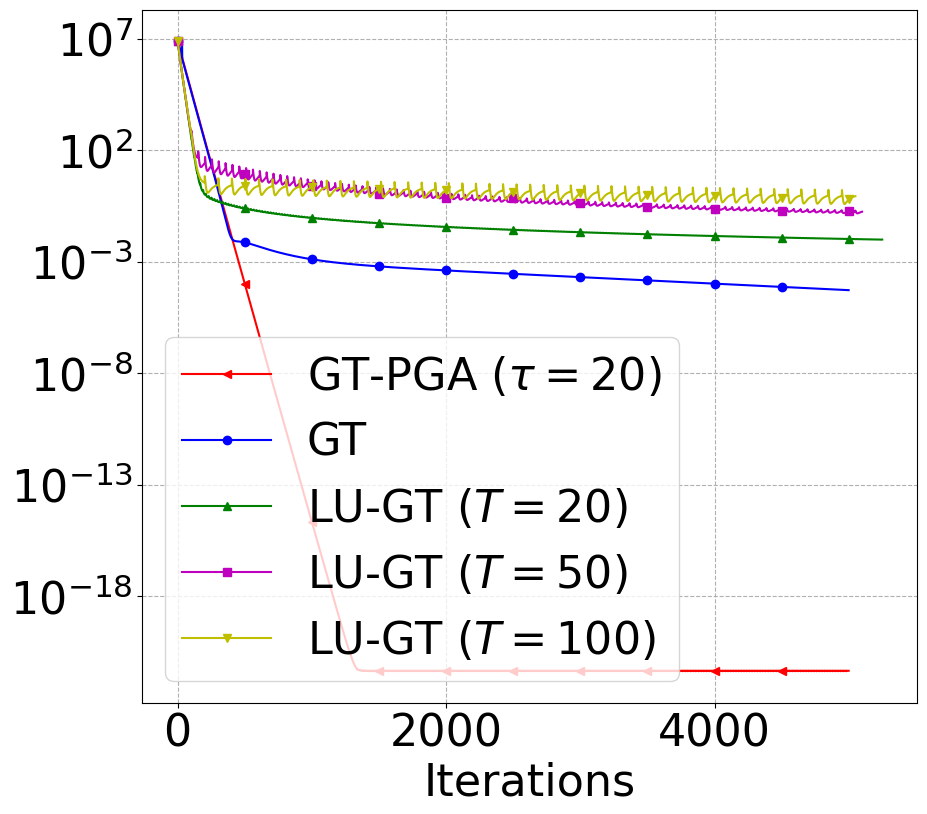

In [11]:
plt_ring = plt.figure(figsize=(10, 9))
interval = 500

plt.plot(ret_ring_GT_with_global_averaging_T20, '-<', label=r'GT-PGA ($\tau=20$)', markevery=interval, color='r')
plt.plot(ret_ring_GT_without_global_averaging, '-o', label='GT', markevery=interval, color='b')
plt.plot(ret_ring_GT_Local_Update_20, '-^', label=r'LU-GT ($T=20$)', markevery=interval, color='g')
plt.plot(ret_ring_GT_Local_Update_50, '-s', label=r'LU-GT ($T=50$)', markevery=interval, color='m')
plt.plot(ret_ring_GT_Local_Update_100, '-v', label=r'LU-GT ($T=100$)', markevery=interval, color='y')

plt.yscale('log')

plt.legend()

# plt.title('Ring', fontsize=20)
plt.xlabel('Iterations', fontsize=32)
plt.ylabel('')
mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rc('legend', fontsize=32)

plt.grid(True, which="both", ls="--")
plt_ring.savefig("ring.pdf", format='pdf')
files.download("ring.pdf")
plt.show()

In [60]:
def run_alg_without_global_averaging(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, reg=0.01, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator(0)

    for ite in notebook.tqdm(range(max_iters)):

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)
      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        # x_curr[:, [a]] /= np.sum(x_curr)
      x_curr = x_curr @ W.T

      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()


    return sum_exponential


In [61]:
def run_alg_Local_Updates(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, ng=5, reg=0.01, noise=False):
    sum_exponential = []

    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator(0)

    for ite in notebook.tqdm(range(max_iters)):
      for n in range(ng) :
        grad_global = grad_fn_global(x_curr, As, bs, reg)
        grad_square_global = np.linalg.norm(grad_global)**2
        grad_average = grad_avg(x_curr, As, bs, reg)
        grad_square_avg = np.linalg.norm(grad_average)**2
        sum_exponential.append(grad_square_global+grad_square_avg)
        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)
      for a in range(num_workers):
        x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
        # x_curr[:, [a]] /= np.sum(x_curr)
      x_curr = x_curr @ W.T

      g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
      for a in range(num_workers):
        y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
        y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
        g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

      x_prev = x_curr.copy()


    return sum_exponential


In [62]:
def run_alg_global_averaging(graph_generator, eta=0.001, alpha=1, T=200, max_iters=10000, reg=0.01, noise=False):
    sum_exponential = []
    x_prev = np.zeros((dimension, num_workers))
    x_curr = np.zeros((dimension, num_workers))
    g_curr = np.zeros((dimension, num_workers))

    for a in range(num_workers):
      g_curr[:, [a]] = alpha * grad_fn_agent(x_curr[:, [a]], As, bs, a, reg, noise)

    W = graph_generator(0)

    for ite in notebook.tqdm(range(max_iters)):

      grad_global = grad_fn_global(x_curr, As, bs, reg)
      grad_square_global = np.linalg.norm(grad_global)**2

      grad_average = grad_avg(x_curr, As, bs, reg)
      grad_square_avg = np.linalg.norm(grad_average)**2

      sum_exponential.append(grad_square_global+grad_square_avg)

      if (ite + 1) % T == 0:

        sum_of_neighbors = np.sum(x_curr - eta * g_curr, axis=1)
        x_curr = np.tile(sum_of_neighbors / num_workers, (num_workers, 1)).T

        sum_of_gradients = np.sum(g_curr, axis=1)
        g_avg = np.tile(sum_of_gradients / num_workers, (num_workers, 1)).T

        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_avg[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()
      else:
        for a in range(num_workers):
          x_curr[:, [a]] = x_prev[:, [a]] - eta *  g_curr[:, [a]]
          # x_curr[:, [a]] /= np.sum(x_curr)
        x_curr = x_curr @ W.T

        g_curr = g_curr @ W.T     # Semi-ATC-GT does not mix the gradients.
        for a in range(num_workers):
          y_curr = grad_fn_agent(x_curr[: ,[a]], As, bs, a, reg, noise)
          y_prev = grad_fn_agent(x_prev[: ,[a]], As, bs, a, reg, noise)
          g_curr[:, [a]] = g_curr[:, [a]] + alpha * (y_curr - y_prev)

        x_prev = x_curr.copy()


    return sum_exponential


In [65]:
factors = [2, 2, 2, 2, 2, 2]
assert int(np.prod(factors)) == num_workers

# ret_static_hc_GT_without_global_averaging_withNoise = run_alg_without_global_averaging(
#     graph_generator=functools.partial(static_hypercuboid, factors=factors),
#     eta=0.0001, alpha=1, max_iters=1000, reg=0.01, noise=True
# )

ret_static_hc_GT_Local_Updates_20_withNoise = run_alg_Local_Updates(
    graph_generator=functools.partial(static_hypercuboid, factors=factors),
    eta=0.0002, alpha=1, T=200, max_iters=50, ng = 20, reg=0.00001, noise=True
)

# ret_static_hc_GT_Local_Updates_50_withNoise = run_alg_Local_Updates(
#     graph_generator=functools.partial(static_hypercuboid, factors=factors),
#     eta=0.0001, alpha=1, T=200, max_iters=20, ng = 50, reg=0.0001, noise=True
# )

# ret_static_hc_GT_Local_Updates_100_withNoise = run_alg_Local_Updates(
#     graph_generator=functools.partial(static_hypercuboid, factors=factors),
#     eta=0.0001, alpha=1, T=200, max_iters=10, ng=100, reg=0.0001, noise=True
# )

# ret_static_hc_GT_with_global_averaging_T20_withNoise = run_alg_global_averaging(
#     graph_generator=functools.partial(static_hypercuboid, factors=factors),
#     eta=0.0001, alpha=1, T=20, max_iters=1000, reg=0.01, noise=True
# )

  0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

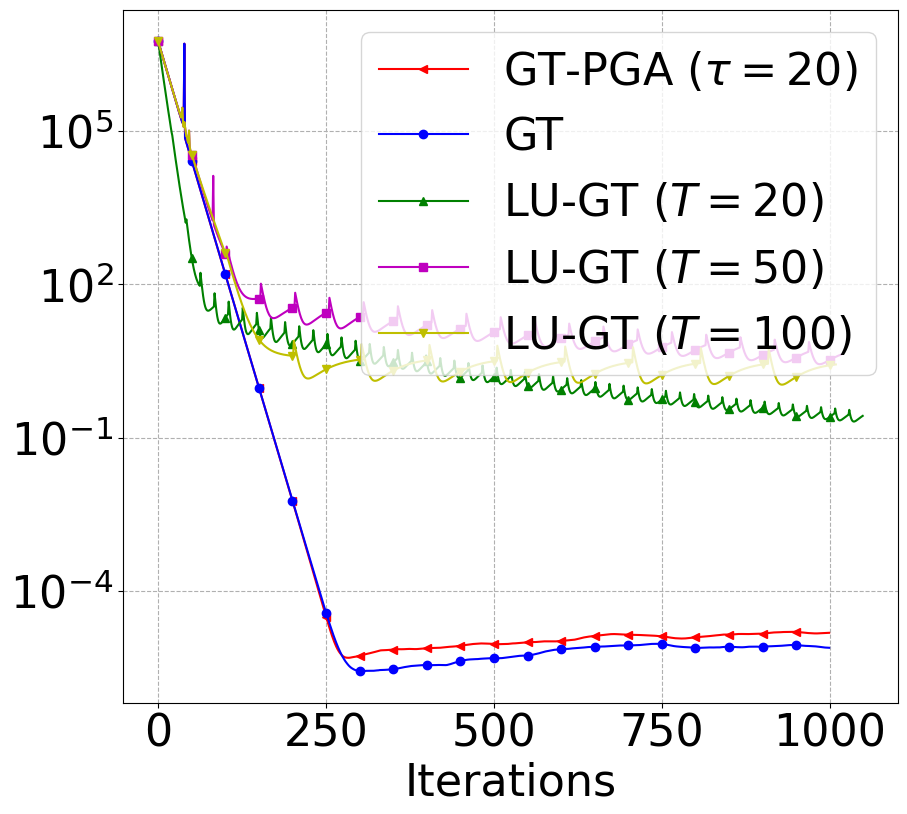

In [66]:
plt_Static_Hypercuboid = plt.figure(figsize=(10, 9))
interval = 50

plt.plot(ret_static_hc_GT_with_global_averaging_T20_withNoise, '-<', label=r'GT-PGA ($\tau=20$)',markevery=interval, color='r')
plt.plot(ret_static_hc_GT_without_global_averaging_withNoise, '-o', label='GT',markevery=interval, color='b')
plt.plot(ret_static_hc_GT_Local_Updates_20_withNoise, '-^', label=r'LU-GT ($T=20$)',markevery=interval, color='g')
plt.plot(ret_static_hc_GT_Local_Updates_50_withNoise, '-s', label=r'LU-GT ($T=50$)',markevery=interval, color='m')
plt.plot(ret_static_hc_GT_Local_Updates_100_withNoise, '-v', label=r'LU-GT ($T=100$)',markevery=interval, color='y')

plt.yscale('log')


plt.legend()

# plt.title('Static hypercuboid', fontsize=32)
plt.xlabel('Iterations', fontsize=32)
plt.ylabel('')
mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rc('legend', fontsize=32)

plt.grid(True, which="both", ls="--")
plt_Static_Hypercuboid.savefig("hypercuboid.pdf", format='pdf')
files.download("hypercuboid.pdf")
plt.show()